In [19]:
library(readr)
library(zoo)
library(data.table)
library(forecast)
library(ggplot2)
library(readxl)
library(lubridate)
library(CCP)
options(warn = -1)

### Introduction


   Buying a house or an apartment is a very common investment type in Turkey. With the increasing house and rent prices, analyzing the real estate market becomes more of an issue. Total house sales is a data set from EVDS and it shows us how many new or second hand houses is being sold monthly in Turkey. To analyze and predict total house sales, consumer loans interest rates, total vehicle sales, and survey results of probability of saving money in 12 months will be used as predictors. 
   In Turkey, people tend to buy new houses in two ways: saving money and getting loan from the banks. So, consumer loan interest rates and survey of probability of saving money in 12 months could be good predictors for forecasting. Vehicle market is another market with high volume in Turkey and people buy cars to make an investment. Total vehicle sales in Turkey might have similarities with total house sales.
   Total house sales, consumer loan interest rates and survey results data sets are taken from EVDS and total vehical sales data set is from TUIK. Observations from 2014 to March 2021 will be analyzed to predict the April 2021 total house sales in Turkey with a multivariate linear regression model. The neccesary data manipulation steps are shown below.

In [2]:
EVDS <- read_excel("C:/Users/kaan9/OneDrive/Masaüstü/EVDS.xlsx")
colnames(EVDS) <- c("Date","total_sales","consumer_interest","prob_saving")
EVDS$Date <- as.Date(as.yearmon(EVDS$Date))
data <- data.table(EVDS)[,`:=`(trend=1:.N,month= as.character(month(Date,label=TRUE)))]
data <- data[,pandemic:=ifelse(Date>="2020-01-01",1,0)]
tuik_vehc <- data.table(read_excel("C:/Users/kaan9/OneDrive/Masaüstü/pivot2.xls"))
colnames(tuik_vehc) <- c("Year","01","02","03","04","05","06","07","08","09","10","11","12")
tuik_vehc[is.na(tuik_vehc)] <- 0
tuik_vehc <- melt(tuik_vehc,id="Year")
tuik_vehc$Date <- as.Date(as.yearmon(paste(as.character(tuik_vehc$Year),as.character(tuik_vehc$variable),sep="-")))
tuik_vehc <- tuik_vehc[,.(vehc_sales=sum(value)),by=.(Date)][order(Date)]
tuik_vehc <- tuik_vehc[Date<="2021-03-01",]
data <- tuik_vehc[data,on=.(Date)]


### Total House Sales

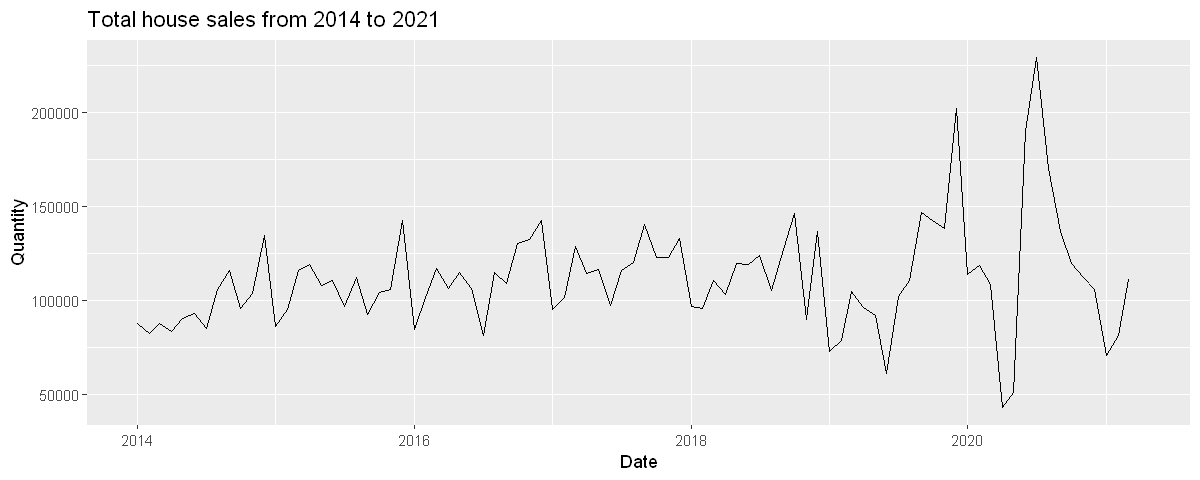

In [3]:
options(repr.plot.width = 10, repr.plot.height = 4)
ggplot(data,aes(x=Date,y=total_sales)) + geom_line() +
labs(title= "Total house sales from 2014 to 2021", x= "Date", y="Quantity")

According to the plot, there is no obvious trend in the data. Number of total sales increases in the last months of the year. There is some seasonality until 2019 however, variance is highly increased after 2019 and continues to increase with the COVID-19 pandemic. Lacking of a distinct trend and high variance are making the data hard to predict. A dummy variable could be used to indicate the pandemic and abnormalities. Trend, seasonality and the pandemic dummy variable will be the first regressors. 


Call:
lm(formula = total_sales ~ trend + month + pandemic, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-60742 -12099   -167  11034 101730 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 110001.0    11147.4   9.868 4.48e-15 ***
trend          222.9      145.9   1.528   0.1309    
monthAra     21781.8    13646.5   1.596   0.1148    
monthEki      2794.6    13637.1   0.205   0.8382    
monthEyl      3966.1    13634.8   0.291   0.7720    
monthHaz     -8268.0    13637.1  -0.606   0.5462    
monthKas     -5451.2    13641.0  -0.400   0.6906    
monthMar     -9445.6    13235.4  -0.714   0.4777    
monthMay    -20329.1    13641.0  -1.490   0.1405    
monthNis    -23890.4    13646.5  -1.751   0.0842 .  
monthOca    -31215.8    13250.7  -2.356   0.0212 *  
monthŞub    -25531.4    13242.2  -1.928   0.0577 .  
monthTem      -457.5    13634.8  -0.034   0.9733    
pandemic       473.4     9740.6   0.049   0.9614    
---
Signif. codes:  0 '***' 0.001

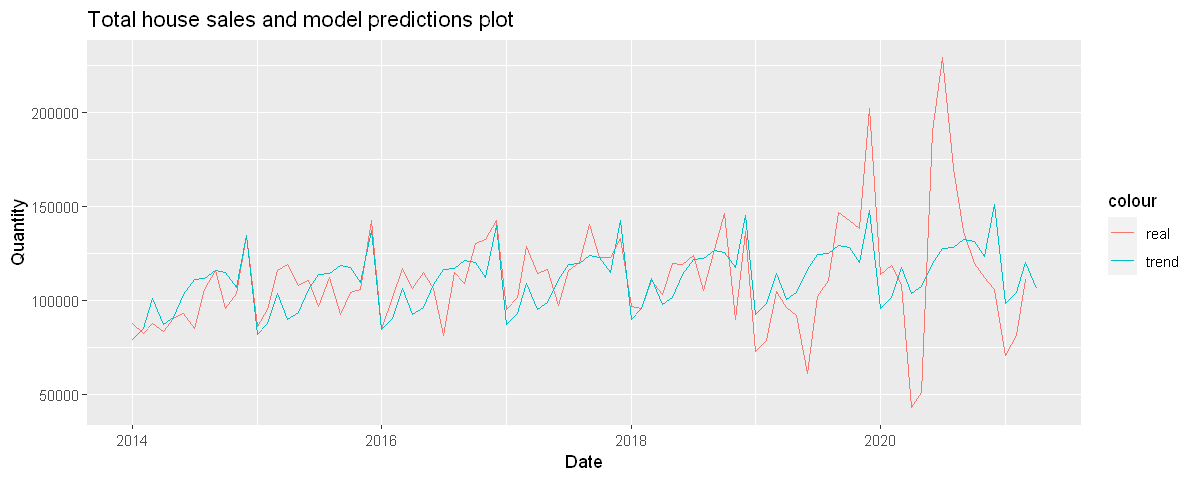

In [4]:
options(repr.plot.width = 10, repr.plot.height = 4)
model <- lm(total_sales~trend+
           month+
           pandemic,
           data=data)
summary(model)
data$output <- predict(model,data)
data$residuals <- c(model$residuals,NA)
ggplot(data ,aes(x=Date)) +
        geom_line(aes(y=total_sales,color='real')) + 
        geom_line(aes(y=output,color='trend')) +
        labs(title= "Total house sales and model predictions plot", x= "Date", y="Quantity")

First model is failed to make accurate predictions as seen in the graph. Adjusted R-squared is 0.1971 and it is very low.

### Total Vehicle Sales

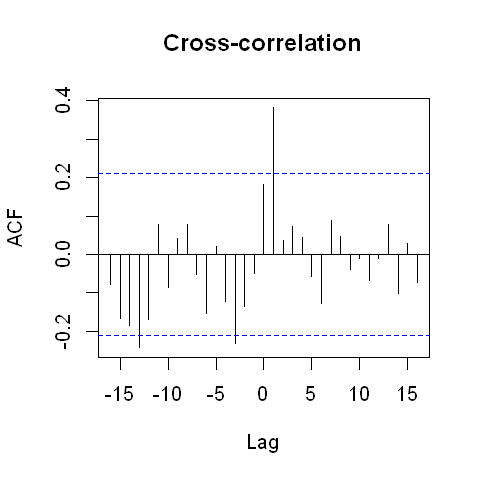

In [5]:
options(repr.plot.width = 4, repr.plot.height = 4)
ccf(data[!is.na(data$vehc_sales),vehc_sales], data[!is.na(data$total_sales),total_sales], main="Cross-correlation")

There is some correaltion between total house sales and total vehicle sales but unfortunately it is not strong.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


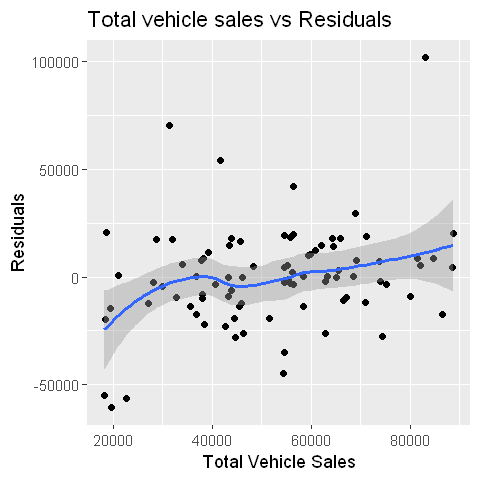

In [6]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(data,aes(x=vehc_sales,y=residuals)) + geom_point() +
labs(title= "Total vehicle sales vs Residuals", x= "Total Vehicle Sales", y="Residuals") +
geom_smooth()

The correlation is being seen on the residual graph. There is some non-linearity which might affect our model. Transformation might be needed. 


Call:
lm(formula = total_sales ~ trend + month + pandemic + vehc_sales, 
    data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-45482 -11146    760   8183  91528 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.251e+04  1.558e+04   4.655 1.44e-05 ***
trend        4.186e+02  1.498e+02   2.795 0.006653 ** 
monthAra     1.470e+04  1.301e+04   1.130 0.262266    
monthEki     8.853e+02  1.283e+04   0.069 0.945201    
monthEyl     8.152e+03  1.288e+04   0.633 0.528901    
monthHaz    -4.744e+03  1.287e+04  -0.369 0.713463    
monthKas    -1.391e+04  1.309e+04  -1.063 0.291457    
monthMar    -1.164e+04  1.246e+04  -0.934 0.353496    
monthMay    -2.054e+04  1.283e+04  -1.602 0.113553    
monthNis    -2.275e+04  1.283e+04  -1.773 0.080532 .  
monthOca    -4.539e+04  1.320e+04  -3.439 0.000974 ***
monthŞub    -1.574e+04  1.281e+04  -1.229 0.223125    
monthTem    -1.097e+04  1.322e+04  -0.830 0.409489    
pandemic    -8.880e+03  9.599e+03  -0.92

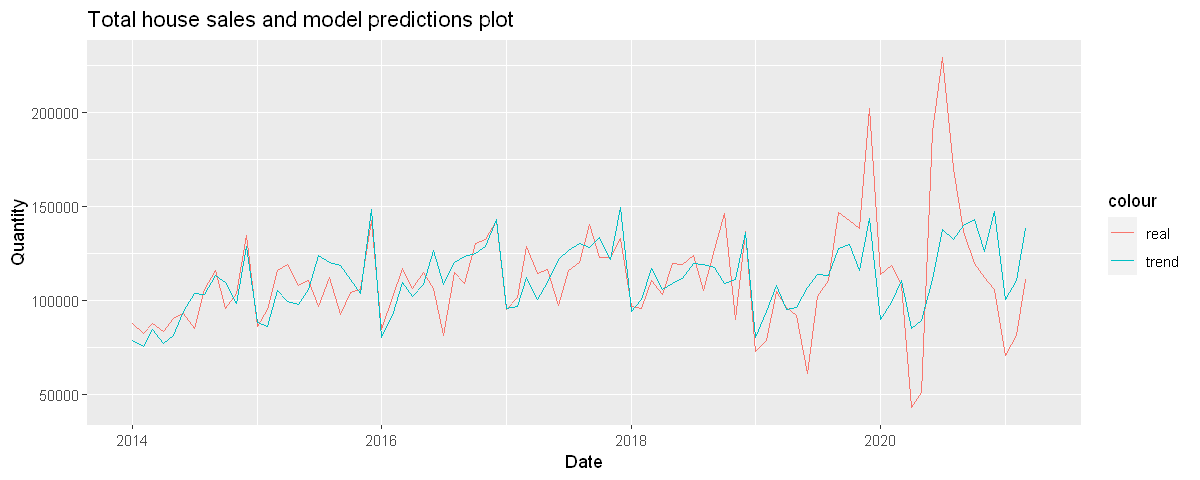

In [7]:
options(repr.plot.width = 10, repr.plot.height = 4)
model <- lm(total_sales~trend+
           month+
           pandemic+
           vehc_sales,
           data=data)
summary(model)
data$output <- predict(model,data)
data$residuals <- c(model$residuals,NA)
ggplot(data ,aes(x=Date)) +
        geom_line(aes(y=total_sales,color='real')) + 
        geom_line(aes(y=output,color='trend')) +
        labs(title= "Total house sales and model predictions plot", x= "Date", y="Quantity")

Although the non-linearity and weak correlation, adjusted R-squared value is increased to 0.2903.

### Consumer Loans Interest Rate

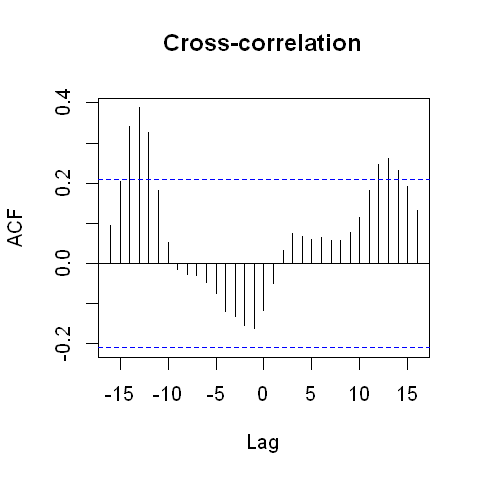

In [8]:
options(repr.plot.width = 4, repr.plot.height = 4)
ccf(data[!is.na(data$consumer_interest),consumer_interest], data[!is.na(data$total_sales),total_sales], main="Cross-correlation")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


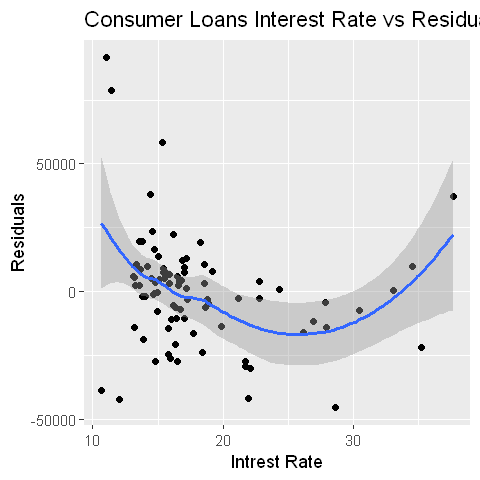

In [9]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(data,aes(x=consumer_interest,y=residuals)) + geom_point() +
labs(title= "Consumer Loans Interest Rate vs Residuals", x= "Intrest Rate", y="Residuals") +
geom_smooth()

Again, there is not strong relation because of the nature of our initial data total house sales. Non-linearity is another problem about this regressor.


Call:
lm(formula = total_sales ~ trend + month + pandemic + vehc_sales + 
    consumer_interest, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-51695  -9266    251   8949  87196 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.014e+05  1.876e+04   5.404 8.27e-07 ***
trend              6.610e+02  1.725e+02   3.832 0.000272 ***
monthAra           1.727e+04  1.258e+04   1.373 0.173987    
monthEki           3.413e+03  1.240e+04   0.275 0.783980    
monthEyl           8.374e+03  1.241e+04   0.675 0.502100    
monthHaz          -6.134e+03  1.241e+04  -0.494 0.622589    
monthKas          -1.045e+04  1.268e+04  -0.824 0.412471    
monthMar          -1.046e+04  1.201e+04  -0.870 0.387038    
monthMay          -2.096e+04  1.236e+04  -1.696 0.094180 .  
monthNis          -2.378e+04  1.237e+04  -1.922 0.058579 .  
monthOca          -3.888e+04  1.297e+04  -2.998 0.003742 ** 
monthŞub          -1.689e+04  1.235e+04  -1.368 0.175665  

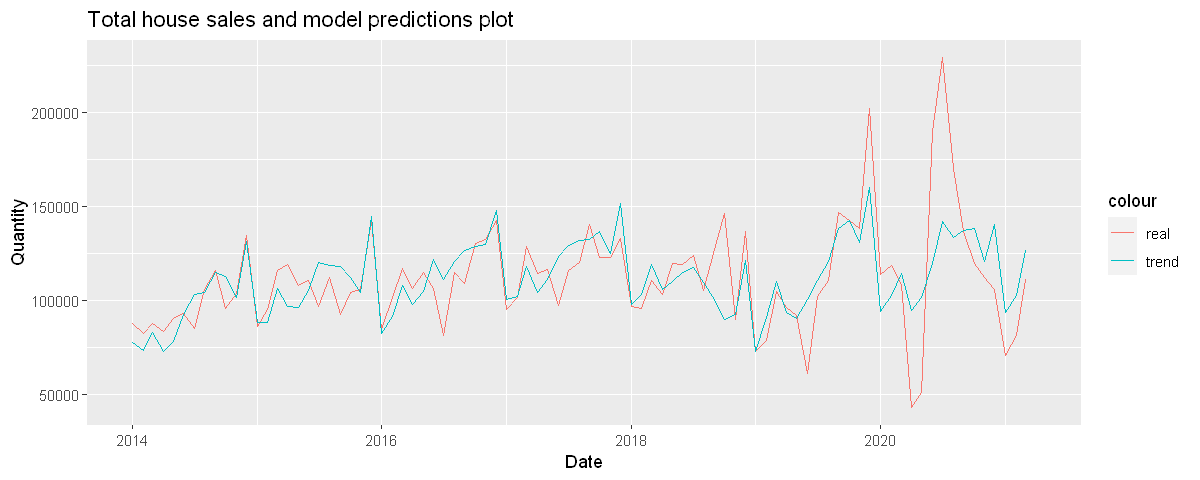

In [10]:
options(repr.plot.width = 10, repr.plot.height = 4)
model <- lm(total_sales~trend+
           month+
           pandemic+
           vehc_sales+
           consumer_interest,
           data=data)
summary(model)
data$output <- predict(model,data)
data$residuals <- c(model$residuals,NA)
ggplot(data ,aes(x=Date)) +
        geom_line(aes(y=total_sales,color='real')) + 
        geom_line(aes(y=output,color='trend')) +
        labs(title= "Total house sales and model predictions plot", x= "Date", y="Quantity")

The model is improved to a better adjusted R-sqared value 0.3413.

### Probability of saving money in 12 months

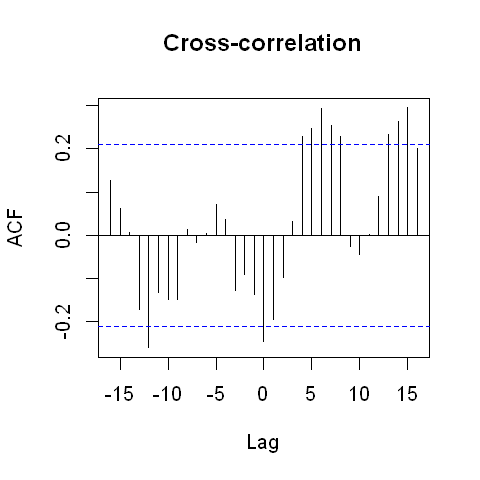

In [11]:
options(repr.plot.width = 4, repr.plot.height = 4)
ccf(data[!is.na(data$prob_saving),prob_saving], data[!is.na(data$total_sales),total_sales], main="Cross-correlation")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


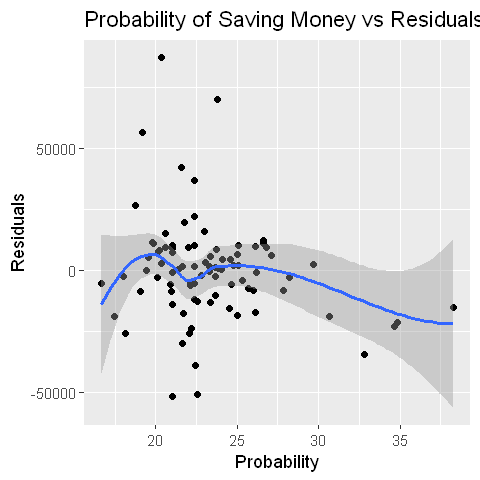

In [12]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(data,aes(x=prob_saving,y=residuals)) + geom_point() +
labs(title= "Probability of Saving Money vs Residuals", x= "Probability", y="Residuals") +
geom_smooth()


Call:
lm(formula = total_sales ~ trend + month + pandemic + vehc_sales + 
    consumer_interest + prob_saving, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-60260 -10278    -53   8823  76367 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.308e+05  2.224e+04   5.879 1.28e-07 ***
trend              6.236e+02  1.683e+02   3.705 0.000419 ***
monthAra           1.329e+04  1.233e+04   1.077 0.285005    
monthEki           1.619e+03  1.207e+04   0.134 0.893649    
monthEyl           4.229e+03  1.219e+04   0.347 0.729604    
monthHaz          -6.141e+03  1.205e+04  -0.510 0.611843    
monthKas          -1.501e+04  1.247e+04  -1.204 0.232799    
monthMar          -1.061e+04  1.167e+04  -0.910 0.366176    
monthMay          -2.119e+04  1.200e+04  -1.766 0.081733 .  
monthNis          -2.014e+04  1.212e+04  -1.662 0.100980    
monthOca          -4.056e+04  1.261e+04  -3.216 0.001971 ** 
monthŞub          -1.430e+04  1.204e+04  -1.

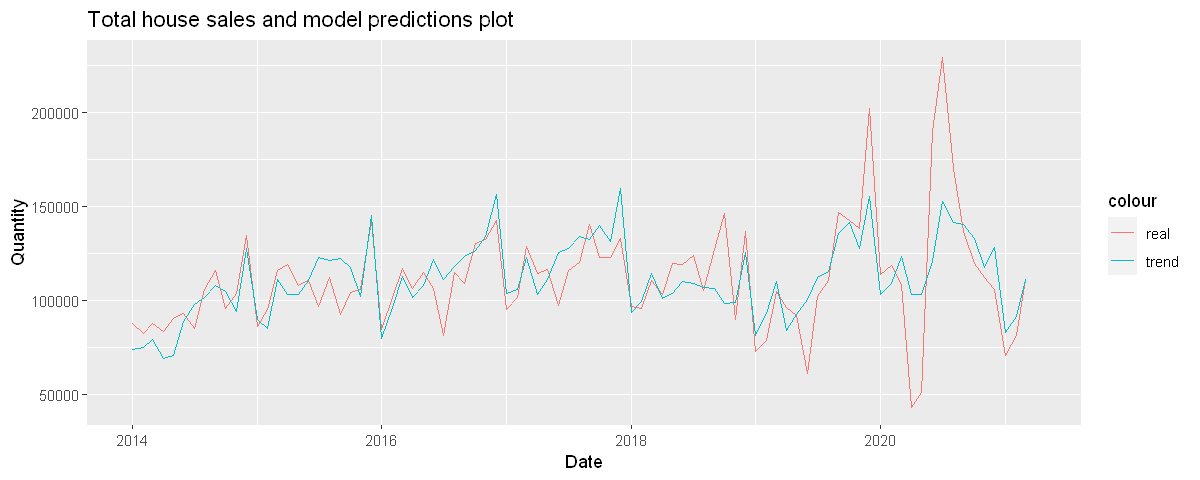

In [13]:
options(repr.plot.width = 10, repr.plot.height = 4)
model <- lm(total_sales~trend+
           month+
           pandemic+
           vehc_sales+
           consumer_interest+
           prob_saving,
           data=data)
summary(model)
data$output <- predict(model,data)
data$residuals <- c(model$residuals,NA)
ggplot(data ,aes(x=Date)) +
        geom_line(aes(y=total_sales,color='real')) + 
        geom_line(aes(y=output,color='trend')) +
        labs(title= "Total house sales and model predictions plot", x= "Date", y="Quantity")

Adding this survey results increased the R-squared value, however the correlation between total house sales and probability of saving is negative which means when people save money, total house sales decreases. Negative corralation violates the main assumption which is people save money to buy houses. Because of the wrong causality, probability of saving shouln't be a predictor in the model.

### Total sales autoregression

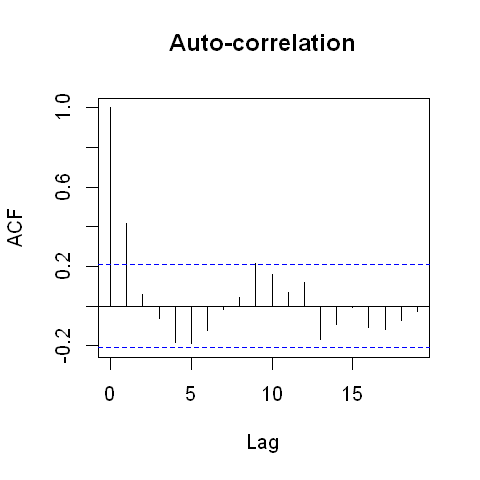

In [14]:
options(repr.plot.width = 4, repr.plot.height = 4)
acf(data[!is.na(data$total_sales),total_sales], main="Auto-correlation")

Because of the loosing one regressor, model's error rate could be increased with adding a lagged total sales predictor. According to auto-correlation graph, 1 month previous observations is highly correlated.


Call:
lm(formula = total_sales ~ trend + month + pandemic + vehc_sales + 
    consumer_interest + shift(total_sales, 1), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-51875  -8651    181   7360  91508 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            6.811e+04  1.968e+04   3.462 0.000926 ***
trend                  5.066e+02  1.688e+02   3.002 0.003733 ** 
monthAra               2.137e+04  1.174e+04   1.820 0.073062 .  
monthEki               1.993e+03  1.153e+04   0.173 0.863260    
monthEyl               6.523e+03  1.154e+04   0.565 0.573785    
monthHaz               4.607e+02  1.167e+04   0.039 0.968621    
monthKas              -9.091e+03  1.178e+04  -0.771 0.443079    
monthMar               2.146e+02  1.155e+04   0.019 0.985221    
monthMay              -1.166e+04  1.176e+04  -0.991 0.324913    
monthNis              -2.095e+04  1.152e+04  -1.818 0.073359 .  
monthOca              -4.401e+04  1.242e+04  -3.545

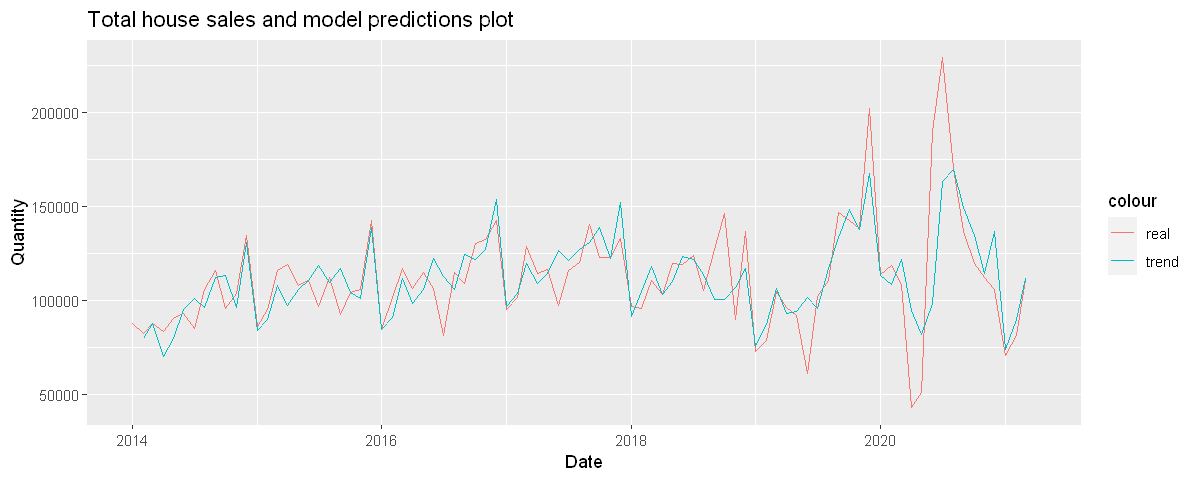

In [15]:
options(repr.plot.width = 10, repr.plot.height = 4)
model <- lm(total_sales~trend+
           month+
           pandemic+
           vehc_sales+
           consumer_interest+
           shift(total_sales,1),
           data=data)
summary(model)
data$output <- predict(model,data)
data$residuals <- c(NA,model$residuals,NA)
ggplot(data ,aes(x=Date)) +
        geom_line(aes(y=total_sales,color='real')) + 
        geom_line(aes(y=output,color='trend')) +
        labs(title= "Total house sales and model predictions plot", x= "Date", y="Quantity")

Adjusted R-squared value is highly increased to 0.4335. As seen in the summary of the model, 1 month lagged total sales regressor is significant.

### Prediction

To predict thetotal house sales quantity of the April 2021, the model needs lagged variables. Optimal lag values in cross-correlation graphs could be taken to shift the observations.


Call:
lm(formula = total_sales ~ trend + month + pandemic + shift(vehc_sales, 
    3) + shift(consumer_interest, 1) + shift(total_sales, 1), 
    data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-56694  -7617   -306   7165  82799 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.132e+05  2.356e+04   4.804 9.14e-06 ***
trend                        4.841e+02  1.819e+02   2.662  0.00972 ** 
monthAra                     2.293e+04  1.149e+04   1.995  0.05015 .  
monthEki                     8.660e+03  1.190e+04   0.728  0.46931    
monthEyl                     2.314e+03  1.145e+04   0.202  0.84044    
monthHaz                    -1.740e+03  1.161e+04  -0.150  0.88129    
monthKas                    -3.796e+03  1.145e+04  -0.331  0.74131    
monthMar                     6.255e+03  1.178e+04   0.531  0.59729    
monthMay                    -1.805e+04  1.227e+04  -1.471  0.14609    
monthNis                    -1.

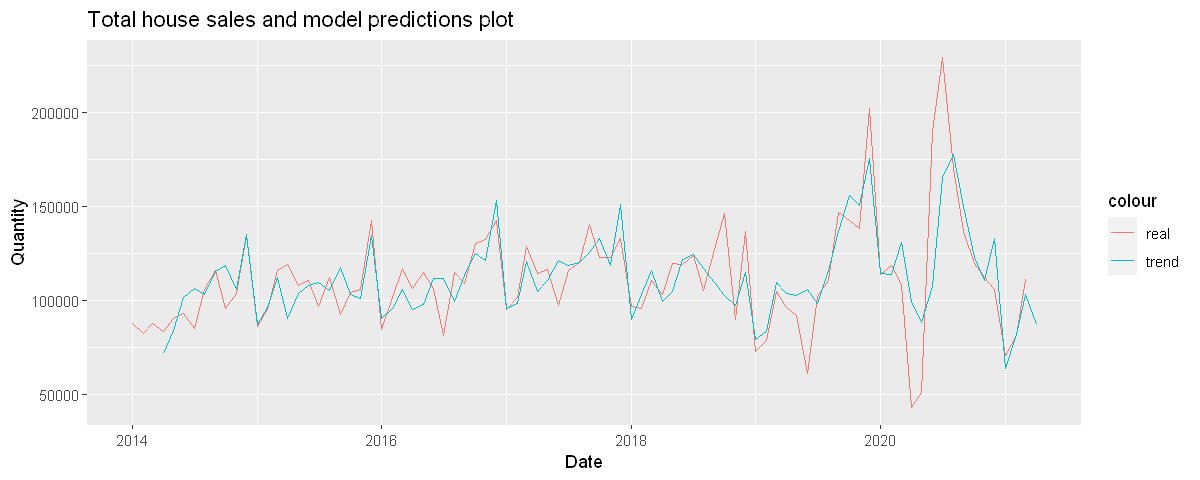

In [16]:
options(repr.plot.width = 10, repr.plot.height = 4)
model <- lm(total_sales~trend+
           month+
           pandemic+
           shift(vehc_sales,3)+
           shift(consumer_interest,1)+
           shift(total_sales,1),
           data=data)
summary(model)
data$output <- predict(model,data)
ggplot(data ,aes(x=Date)) +
        geom_line(aes(y=total_sales,color='real')) + 
        geom_line(aes(y=output,color='trend')) +
        labs(title= "Total house sales and model predictions plot", x= "Date", y="Quantity")

### Residual Analysis


	Breusch-Godfrey test for serial correlation of order up to 20

data:  Residuals
LM test = 36.748, df = 20, p-value = 0.01254


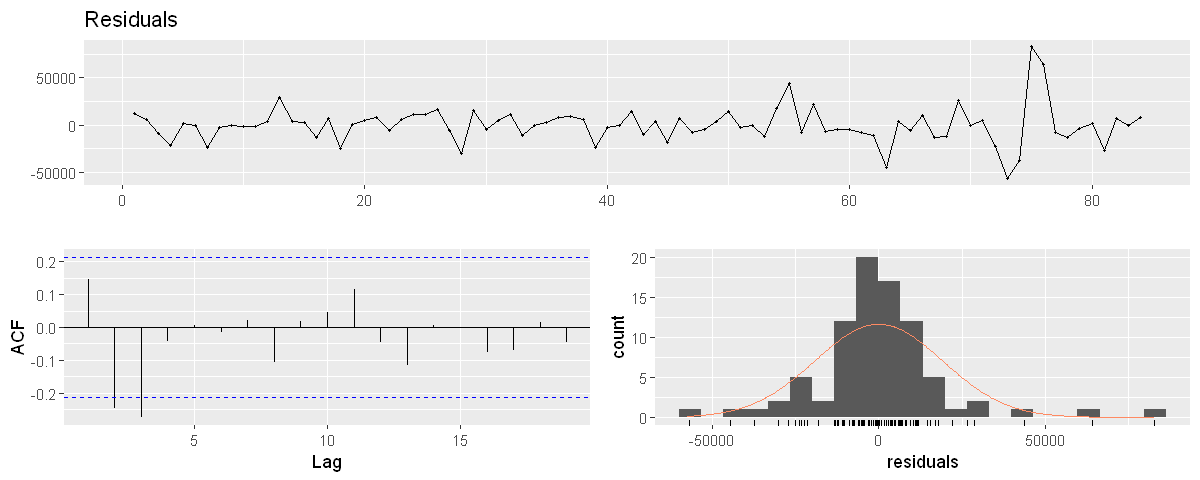

In [17]:
checkresiduals(model)

Residuals of the model looks some what random. There is some correlation between errors and they seem as a normal distribution. The p-value is 0.012 which is low but adjusted R-squared value is 0.44. Residual standart error is 21320 which means the model could predict 21 thousands of sales more or less from the actual sales.

### Conclusion

In [18]:
print(" Prediction for April 2021: ")
round(data$output[nrow(data)])

[1] " Prediction for April 2021: "


[1] 87140

Model predicts the total house sales of Turket at April 2021 as 87140. However, because of the high error rates, this isn't a good model to forecast total house sales in Turkey. The data set need further analyses and improved models.